In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from time import time

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#### About 20_newsgroups data set
The returned dataset after fetch_20newsgroups function is a scikit-learn “bunch”: a simple holder object with fields that can be both accessed as python dict keys or object attributes for convenience, for instance the target_names holds the list of the requested category names:

In [137]:
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
train_20_newsgroups = fetch_20newsgroups(subset='train', shuffle=True, categories = categories, random_state = 21)

The files are loaded in memory in the data attribute. 

In [136]:
print('The following newsgroups will be trained', train_20_newsgroups.target_names)
print('The no of sentences', len(train_20_newsgroups.data))

The following newsgroups will be trained ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
The no of sentences 2257


Printing the first loaded file and first line of the file. For speed and space efficiency reasons scikit-learn loads the target attribute as an array of integers that corresponds to the index of the category name in the target_names list. The category integer id of each sample is stored in the target attribute:

In [4]:
print("\n".join(train_20_newsgroups.data[0].split("\n")[:3]))
print('File name: ', train_20_newsgroups.target_names[train_20_newsgroups.target[0]])

From: ederveen@athena.research.ptt.nl (Ederveen D.)
Subject: Micro World Data Bank II ?
Nntp-Posting-Host: athena.research.ptt.nl
File name:  comp.graphics


#### Create test data set

In [48]:
test_20_newsgroups = fetch_20newsgroups(subset = 'test', shuffle = True, categories = categories, random_state = 21)
docs_test_20_newsgroups = test_20_newsgroups.data
print('Keys: ',test_20_newsgroups.keys(),  '\nTarget Names: ',test_20_newsgroups.target_names)
#test_20_newsgroups.target_names

Keys:  dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR']) 
Target Names:  ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


#### Remove stop words: Remove special characters

In [143]:
##Find the number of sentenes for each target names
import pandas as pd
df = pd.DataFrame({ key:pd.Series(value) for key, value in train_20_newsgroups.items() })
col = ['target_names', 'data']
#df = df[col]
df = df[pd.notnull(df['target_names'])]
df = df[col]
df

#df = df[pd.notnull(df['Consumer complaint narrative'])]


,target_names,data
0,alt.atheism,From: ederveen@athena.research.ptt.nl (Edervee...
1,comp.graphics,From: bockamp@Informatik.TU-Muenchen.DE (Flori...
2,sci.med,From: dgf1@quads.uchicago.edu (Dr. Eldon Tyrel...
3,soc.religion.christian,From: mccurdy@ucsvax.sdsu.edu (McCurdy M.)\nSu...


#### Find the occurrances of the word (Bag of Words) using CountVectorizer
Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors. CountVectorizer converts a collection of text documents to a matrix of token counts

#### Find the frequency of the occurrances of the word using TF-IDF

In [257]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_20_newsgroups.data)

In [258]:
#print(count_vect.get_feature_names())
print(X_train_counts.shape)

(2257, 35788)


In [52]:
print(X_train_counts.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [61]:
tfidf_trans = TfidfTransformer(use_idf = True) #(2257, 35788) - False
X_train = tfidf_trans.fit_transform(X_train_counts)
print(X_train.toarray())
print(X_train.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2257, 35788)


In [54]:
print('Learning Freq', tfidf_trans.idf_)

Learning Freq [4.62633894 4.70430048 7.62207121 ... 6.52345892 7.62207121 6.92892403]


In [63]:
clf = MultinomialNB().fit(X_train, train_20_newsgroups.target)

#### Training a NB classifier and testing the prediction

In [64]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_trans.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, test_20_newsgroups.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


#### Building a pipeline and training using Multinomial NB
In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier: 

In [248]:
t0 = time()
nb_clf = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())
                 ])
nb_clf.fit(train_20_newsgroups.data, train_20_newsgroups.target)
print('Time taken to execute NB Classifier: ', round((time() -t0),2),'secs')
nb_predict = nb_clf.predict(test_20_newsgroups.data)
print('NB Prediction Accuracy- ',round((np.mean(nb_predict == test_20_newsgroups.target))*100,2),'%')
print(metrics.classification_report(test_20_newsgroups.target, nb_predict, target_names = test_20_newsgroups.target_names))

Time taken to execute NB Classifier:  1.13 secs
NB Prediction Accuracy-  83.49 %
                        precision    recall  f1-score   support

           alt.atheism       0.97      0.60      0.74       319
         comp.graphics       0.96      0.89      0.92       389
               sci.med       0.97      0.81      0.88       396
soc.religion.christian       0.65      0.99      0.78       398

             micro avg       0.83      0.83      0.83      1502
             macro avg       0.89      0.82      0.83      1502
          weighted avg       0.88      0.83      0.84      1502



#### Evaluate the performance of test data using Naive Bayes

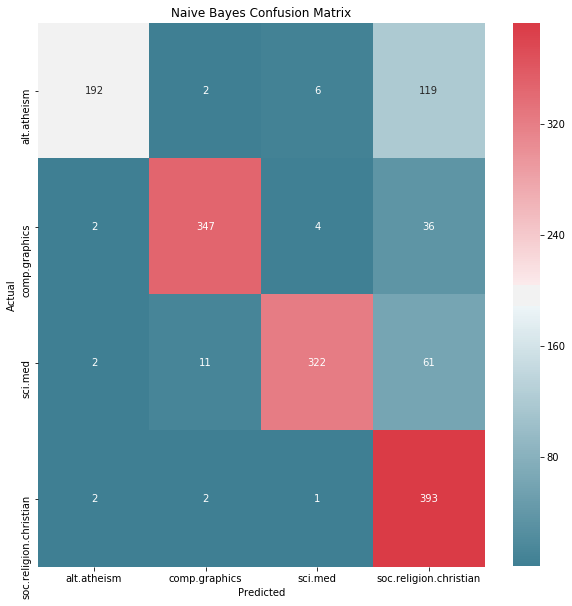

In [179]:
nb_conf_mat = metrics.confusion_matrix(test_20_newsgroups.target, predict_test_data)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(nb_conf_mat, annot=True, fmt='d', cmap=sns.diverging_palette(220,10, as_cmap=True),
            xticklabels = test_20_newsgroups.target_names, yticklabels = test_20_newsgroups.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [124]:
### Do a prediction
test_doc = ['God is love', 'Are you crazy:', 'Love is eternal', 'Machine Learning w/ computer is the way to go']
test_nb_predict = nb_clf.predict(test_doc)
print('Test prediction: ', test_nb_predict)


for test_doc, category in zip(test_doc, test_nb_predict):
    print('%r => %s' % (test_doc, test_20_newsgroups.target_names[category]))

Test prediction:  [3 0 3 2]
'God is love' => soc.religion.christian
'Are you crazy:' => alt.atheism
'Love is eternal' => soc.religion.christian
'Machine Learning w/ computer is the way to go' => sci.med


### Testing results with SVM - SGD with hinge parameter

In [247]:
from sklearn.feature_extraction.text import TfidfVectorizer 
print("Support Vector Machine Algorithm for classification")
t0 = time()
svm_clf = Pipeline([('vect', TfidfVectorizer(sublinear_tf=True , norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
                    ('clf', SGDClassifier(loss = 'hinge', penalty ='l2', alpha=1e-3, n_iter=5, random_state=21) )
                   ])
svm_clf.fit(train_20_newsgroups.data, train_20_newsgroups.target)
print('Time taken to execute SVC-SGD Classifier: ', round((time() -t0),2),'secs')
svm_predict = svm_clf.predict(test_20_newsgroups.data)
print('SVM prediction: ', round((np.mean(svm_predict == test_20_newsgroups.target))*100,2),'%')

Support Vector Machine Algorithm for classification


C:\Users\Yasim\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Time taken to execute SVC-SGD Classifier:  3.8 secs
SVM prediction:  91.94 %


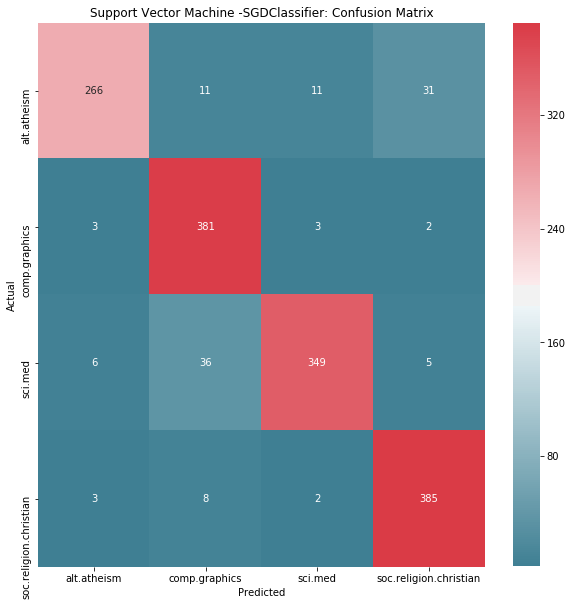

In [182]:
svm_conf_mat = metrics.confusion_matrix(test_20_newsgroups.target, svm_predict)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(svm_conf_mat, annot=True, fmt='d', cmap = sns.diverging_palette(220,10, as_cmap=True),
            xticklabels=test_20_newsgroups.target_names , yticklabels= test_20_newsgroups.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Support Vector Machine -SGDClassifier: Confusion Matrix')
plt.show()

###  Testing results with LinearSVC (Most preferred classifier based on results)

In [249]:
print("LinearSVC with L1/2 based feature selection")
# The more regularization, the more sparsity.
t0 = time()
lsvc_clf = Pipeline([('vect', TfidfVectorizer(sublinear_tf=True , norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
                     ('clf', LinearSVC(penalty = 'l2', dual = False, multi_class='ovr', tol=0.0001, random_state=21))
                    ])
lsvc_clf.fit(train_20_newsgroups.data, train_20_newsgroups.target)
print('Time taken to execute LinearSVC: ', round((time() -t0),2),'secs')
lsvc_predict = lsvc_clf.predict(test_20_newsgroups.data)
print('Linear SVC Prediction Accuracy: ',round((np.mean(lsvc_predict == test_20_newsgroups.target))*100,2),'%')

LinearSVC with L1/2 based feature selection
Time taken to execute LinearSVC:  5.98 secs
Linear SVC Prediction Accuracy:  93.14 %


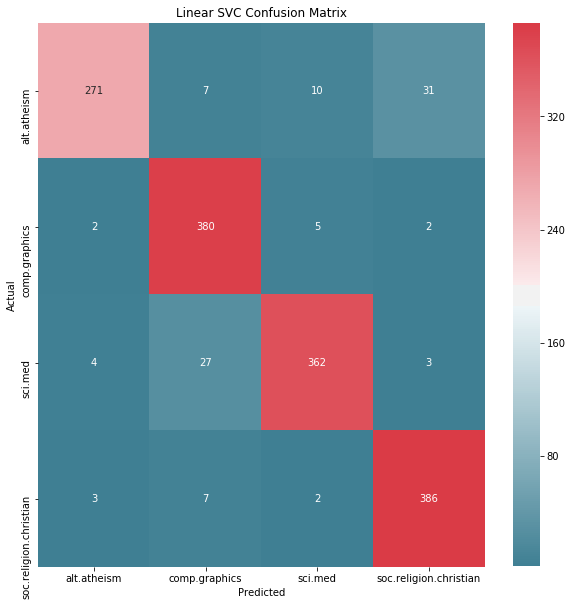

In [180]:
lsvc_conf_mat = metrics.confusion_matrix(test_20_newsgroups.target, lsvc_predict)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(lsvc_conf_mat, annot=True, fmt='d', cmap = sns.diverging_palette(220,10, as_cmap=True),
            xticklabels=test_20_newsgroups.target_names , yticklabels= test_20_newsgroups.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Linear SVC Confusion Matrix')
plt.show()

### Testing results with RandomForestClassifier

In [250]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = Pipeline([('vect', TfidfVectorizer(sublinear_tf=True , norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
                    ('clf' ,RandomForestClassifier(n_estimators = 200, max_depth=25, random_state=21))
                  ])
rf_clf.fit(train_20_newsgroups.data, train_20_newsgroups.target)
print('Time taken by RandomForestClassifier: ', round((time() -t0),2),'secs')
rf_clf_predict = rf_clf.predict(test_20_newsgroups.data)
print('RF Classsifier Prediction Accuracy: ', round((np.mean(rf_clf_predict == test_20_newsgroups.target))*100,2),'%')

Time taken by RandomForestClassifier:  10.07 secs
RF Classsifier Prediction Accuracy:  78.96 %


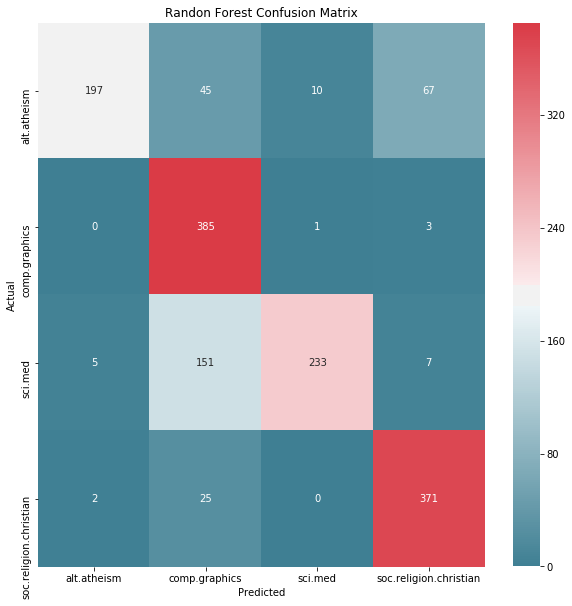

In [233]:
rf_conf_mat = metrics.confusion_matrix(test_20_newsgroups.target, rf_clf_predict)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(rf_conf_mat, annot=True, fmt='d', cmap = sns.diverging_palette(220,10, as_cmap=True),
            xticklabels=test_20_newsgroups.target_names , yticklabels= test_20_newsgroups.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Randon Forest Confusion Matrix')
plt.show()

### Testing results with Decision Tree

In [254]:
  ## Decision Tree
from sklearn.tree import DecisionTreeClassifier
print('Decision tree classifier')
t0 = time()
dt_clf = Pipeline([('vect', TfidfVectorizer(sublinear_tf = True, norm='l2', ngram_range=(1, 2), stop_words = 'english')),
                   ('clf', DecisionTreeClassifier(random_state=21)) ### max_depth=25
                  ])
dt_clf.fit(train_20_newsgroups.data, train_20_newsgroups.target)
print('Time taken to Execute Decision Tree: ', round((time() -t0),2),'secs')
dt_clf_predict = dt_clf.predict(test_20_newsgroups.data)
print('Decision tree Prediction Accuracy: ', round((np.mean(dt_clf_predict == test_20_newsgroups.target))*100,2),'%')

Decision tree classifier
Time taken to Execute Decision Tree:  9.45 secs
Decision tree Prediction Accuracy:  69.31 %


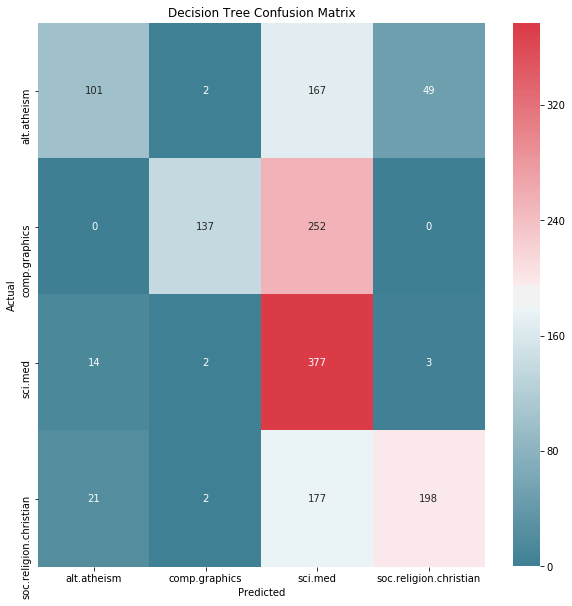

In [208]:
dt_clf_mat = metrics.confusion_matrix(test_20_newsgroups.target, dt_clf_predict)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(dt_clf_mat, annot=True, fmt='d', cmap=sns.diverging_palette(220,10, as_cmap=True),
           xticklabels = test_20_newsgroups.target_names, yticklabels = test_20_newsgroups.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Decision Tree Confusion Matrix')
plt.show()

### Testing results with K Nearest Neighbor classifier

In [253]:
  ## Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
print('K Nearest Neighbor classifier')
t0 = time()
knn_clf = Pipeline([('vect', TfidfVectorizer(sublinear_tf = True, norm='l2', ngram_range=(1,2), stop_words = 'english')),
                    ('clf', KNeighborsClassifier(n_neighbors=5))
                   ])
        
knn_clf.fit(train_20_newsgroups.data, train_20_newsgroups.target)
print('Time taken to execute KNN: ', round((time() -t0),2),'secs')
knn_clf_predict = knn_clf.predict(test_20_newsgroups.data)
print('K Nearest Neighbor Prediction Accuracy: ', round((np.mean(knn_clf_predict == test_20_newsgroups.target))*100,2),'%')

K Nearest Neighbor classifier
Time taken to execute KNN:  3.2 secs
K Nearest Neighbor Prediction Accuracy:  84.02 %


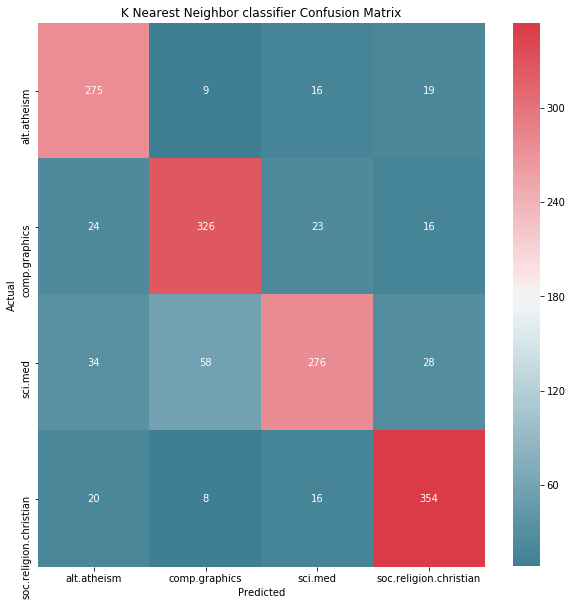

In [215]:
knn_clf_mat = metrics.confusion_matrix(test_20_newsgroups.target, knn_clf_predict)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(knn_clf_mat, annot=True, fmt='d', cmap=sns.diverging_palette(220,10, as_cmap=True),
           xticklabels = test_20_newsgroups.target_names, yticklabels = test_20_newsgroups.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('K Nearest Neighbor classifier Confusion Matrix')
plt.show()

#### The final chosen algorithm chosen based on the prediction accuracy and based on confusion matrix is linear SVC. 
#### Calculate other metrics for Linear SVC such as precision, recall, F1 score etc. 

In [256]:
print('Linear SVC Prediction Accuracy: ',round((np.mean(lsvc_predict == test_20_newsgroups.target))*100,2),'%')
print(metrics.classification_report(test_20_newsgroups.target, lsvc_predict, target_names = test_20_newsgroups.target_names))

Linear SVC Prediction Accuracy:  93.14 %
                        precision    recall  f1-score   support

           alt.atheism       0.97      0.85      0.90       319
         comp.graphics       0.90      0.98      0.94       389
               sci.med       0.96      0.91      0.93       396
soc.religion.christian       0.91      0.97      0.94       398

             micro avg       0.93      0.93      0.93      1502
             macro avg       0.94      0.93      0.93      1502
          weighted avg       0.93      0.93      0.93      1502

